In [2]:
import tensorflow as tf
# from tensorflow.keras.layers import (
#     Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation,
#     BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D)
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.optimizers import Adam, RMSprop

from keras.layers import (
    Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation,
    BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D)
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.utils import plot_model
from keras.initializers import RandomNormal
from keras.losses import binary_crossentropy

import numpy as np
import json
import os
import pickle as pkl
import matplotlib.pyplot as plt

from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Let's train on cars first. Might be more interesting for the case of insurance.
car_label = 1 # Cifar has 1 for automobiles.
horse_label = 7 # Cifar has 7 for horses
bird_label = 2 

train_mask = [y[0] == bird_label for y in y_train]
test_mask = [y[0] == bird_label for y in y_test]

x_train = x_train[train_mask]
y_train = y_train[train_mask]
x_test = x_test[test_mask]
y_test = y_test[test_mask]

assert x_train.shape[0] == y_train.shape[0] # Number of data points is the same.
assert x_test.shape[0] == y_test.shape[0]

def wasserstein(y_true, y_pred):
    return -K.mean(y_true * y_pred)

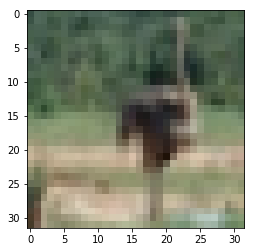

In [3]:
plt.imshow((x_train[150,:,:,:])) # Why is there a +1, /2 in the original?

In [4]:
input_dim = x_train[0].shape

critic_input = Input(shape = input_dim, name = 'critic_input')

x = critic_input
x = Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = 'same', 
           name = 'critic_conv_0', kernel_initializer = 'glorot_uniform')(x)
x = LeakyReLU()(x)
x = Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = 'same',
           name = 'critic_conv_1', kernel_initializer = 'glorot_uniform')(x)
x = LeakyReLU()(x)
x = Conv2D(filters = 128, kernel_size = 5, strides = 2, padding = 'same',
           name = 'critic_conv_2', kernel_initializer = 'glorot_uniform')(x)
x = LeakyReLU()(x)
x = Conv2D(filters = 128, kernel_size = 5, strides = 1, padding = 'same',
           name = 'critic_conv_3', kernel_initializer = 'glorot_uniform')(x)
x = LeakyReLU()(x)
x = Flatten()(x)
# No activation

critic_output = Dense(1, activation = None, kernel_initializer = 'glorot_uniform')(x)

critic = Model(critic_input, critic_output)
critic.compile(Adam(lr = 0.00005), loss = wasserstein)

In [5]:
z_dim = 100
generator_initial_dense_layer_size = (4,4,128)
generator_input = Input(shape = (z_dim,), name = 'generator_input')

x = generator_input
x = Dense(np.prod(generator_initial_dense_layer_size),
          kernel_initializer = 'glorot_uniform')(x)
x = BatchNormalization(momentum = 0.8)(x)
x = LeakyReLU()(x)
x = Reshape(generator_initial_dense_layer_size)(x)
x = UpSampling2D()(x)
x = Conv2D(filters = 128, kernel_size = 5, strides = 1, padding = 'same',
           name = 'generator_conv_0', kernel_initializer = 'glorot_uniform')(x)
x = BatchNormalization(momentum = 0.8)(x)
x = LeakyReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(filters = 64, kernel_size = 5, strides = 1, padding = 'same',
           name = 'generator_conv_1', kernel_initializer = 'glorot_uniform')(x)
x = BatchNormalization(momentum = 0.8)(x)
x = LeakyReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = 'same',
           name = 'generator_conv_2', kernel_initializer = 'glorot_uniform')(x)
x = LeakyReLU()(x)
x = BatchNormalization(momentum = 0.8)(x)
x = Conv2DTranspose(filters = 3, kernel_size = 5, strides = 1, padding = 'same',
                    name = 'generator_conv_3', kernel_initializer = 'glorot_uniform')(x)
x = Activation('tanh')(x)
generator_output = x

generator = Model(generator_input, generator_output)

# Now compile the adversary, need to confirm critic is not training.
for l in critic.layers:
    l.trainable = False
critic.trainable = False
    
adversarial_input = Input(shape = (z_dim,), name = 'adversarial_input')
adversarial_ouput = critic(generator(adversarial_input))
adversarial = Model(adversarial_input, adversarial_ouput)
adversarial.compile(Adam(lr = 0.00005), loss = wasserstein)

# And then you can let the critic train again
for l in critic.layers:
    l.trainable = True
critic.trainable = True
# By the way, since there is no model compilation after changing trainable there is no need
# to do this, it's just to shut off some warning messages.

In [6]:
# Ok now that we are sure they are the same, let's just go for the throat.
batch_size = 128
epochs = 6000
print_every_n_batches = 1000
n_critic = 5
clip_threshold = 0.01

In [ ]:
%%time
for epoch in range(epochs):
    for _ in range(n_critic): # Critic is trained a bunch of times before gen.
        valid = np.ones((batch_size,1))
        fake = np.ones((batch_size,1))
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        true_imgs = x_train[idx]

        noise = np.random.normal(0,1, (batch_size, z_dim))
        gen_imgs = generator.predict(noise)

        d_loss_real = critic.train_on_batch(true_imgs, valid)
        d_loss_fake = critic.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        for l in critic.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -clip_threshold, clip_threshold) for w in weights]
            l.set_weights(weights)

        # The way this is setup, the name epoch is a lie. It's just how many batches we're 
        # pulling out.

        g_loss = adversarial.train_on_batch(noise, valid)
        # Notice that you do not call generator.train_on_batch. Generator should be trained
        # in the adversarial setting.

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


CPU times: user 1h 3min 21s, sys: 11min 32s, total: 1h 14min 54s
Wall time: 1h 16min 50s


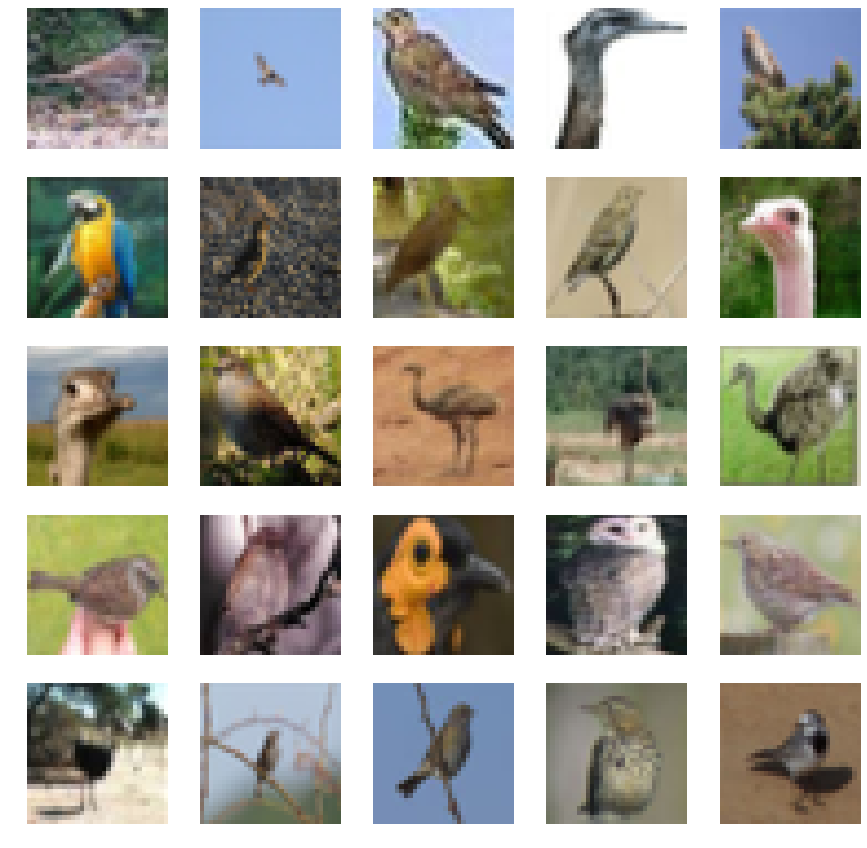

In [15]:
r, c = 5, 5

idx = np.random.randint(0, x_train.shape[0], batch_size)
# true_imgs = (x_train[idx] + 1) *0.5 # Why are we doing this?
true_imgs = x_train[idx]

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(true_imgs[cnt], cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
# fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"))
# plt.close()

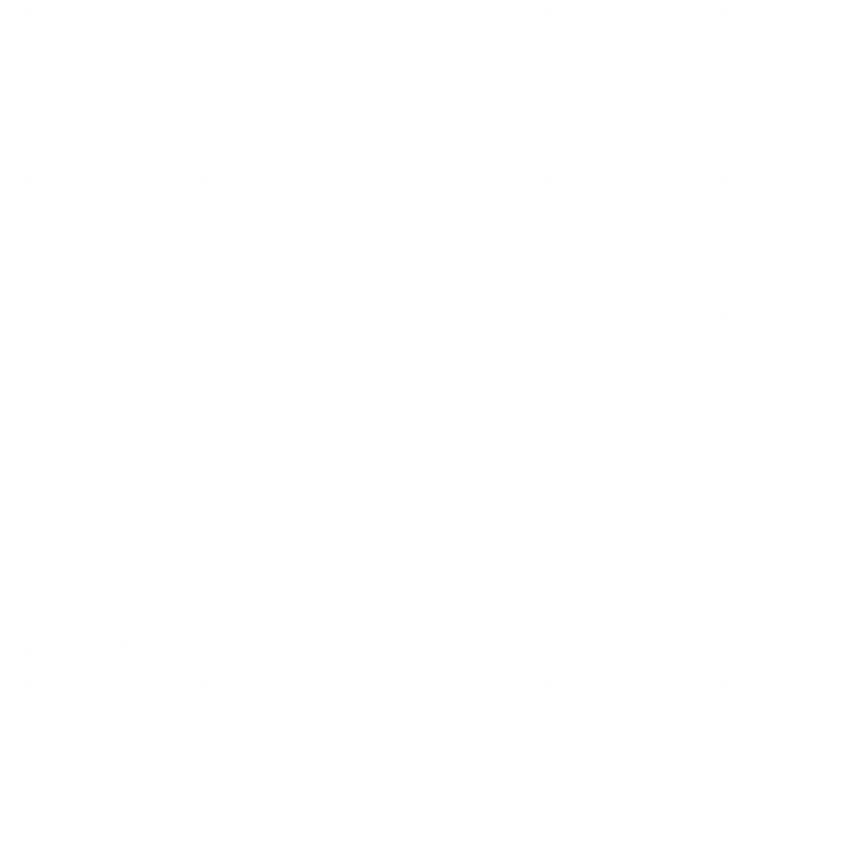

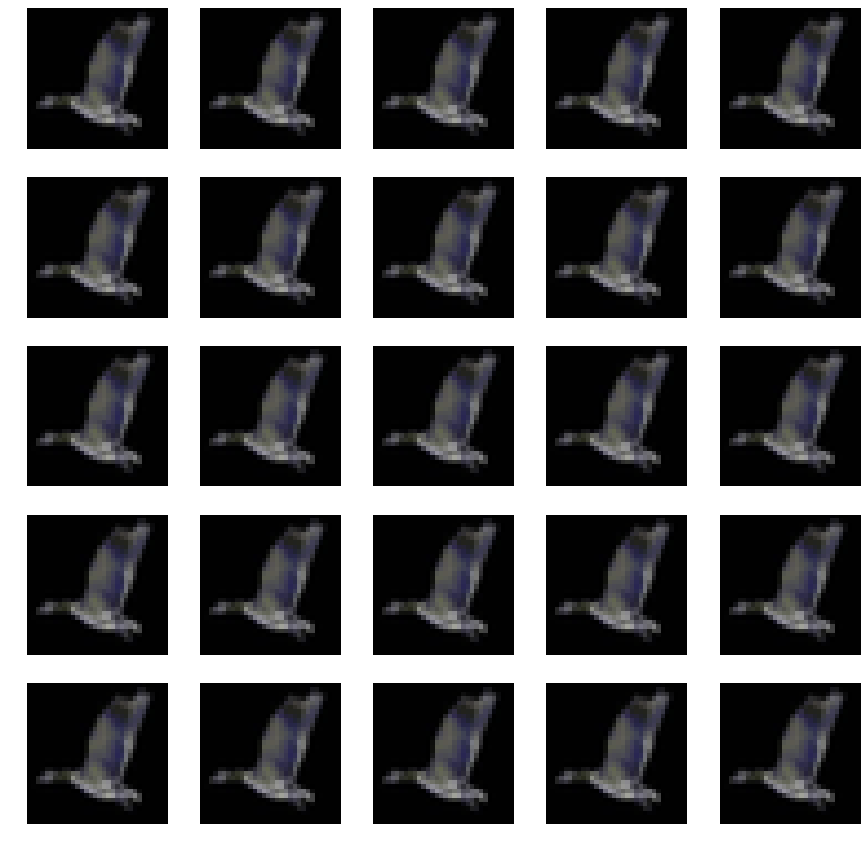

In [19]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, z_dim))
gen_imgs = generator.predict(noise)

#Rescale images 0 - 1

# gen_imgs = 0.5 * (gen_imgs + 1)
# gen_imgs = np.clip(gen_imgs, 0, 1)

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
# fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"))
# plt.close()


fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train)):
#         for k_idx, k in enumerate((x_train + 1) * 0.5):
            
            diff = compare_images(gen_imgs[cnt, :,:,:], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1

# fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"))
# plt.close()

# What this part is supposed to do - show first the generated images, and then the 25 images
# from the train set that is closest to those 25. But it looks like just changing the labels
# destroyed everything.

## architecture

In [5]:
if mode == 'build':

    gan = WGAN(input_dim = (32,32,3)
            , critic_conv_filters = [32,64,128,128]
            , critic_conv_kernel_size = [5,5,5,5]
            , critic_conv_strides = [2,2,2,1]
            , critic_batch_norm_momentum = None
            , critic_activation = 'leaky_relu'
            , critic_dropout_rate = None
            , critic_learning_rate = 0.00005
            , generator_initial_dense_layer_size = (4, 4, 128)
            , generator_upsample = [2,2, 2,1]
            , generator_conv_filters = [128,64,32,3]
            , generator_conv_kernel_size = [5,5,5,5]
            , generator_conv_strides = [1,1, 1,1]
            , generator_batch_norm_momentum = 0.8
            , generator_activation = 'leaky_relu'
            , generator_dropout_rate = None
            , generator_learning_rate = 0.00005
            , optimiser = 'rmsprop'
            , z_dim = 100
            )
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [6]:
gan.critic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
critic_conv_0 (Conv2D)       (None, 16, 16, 32)        2432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
critic_conv_1 (Conv2D)       (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
critic_conv_2 (Conv2D)       (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 128)         0         
__________

In [7]:
gan.generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              206848    
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 128)         0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 8, 8, 128)         409728    
__________

## training

In [8]:
BATCH_SIZE = 128
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 1000
N_CRITIC = 5
CLIP_THRESHOLD = 0.01

In [9]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , clip_threshold = CLIP_THRESHOLD
)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: (-0.000)(R -0.001, F 0.000)]  [G loss: -0.001] 


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: (-0.000)(R -0.001, F 0.001)]  [G loss: -0.000] 
2 [D loss: (-0.000)(R -0.001, F 0.001)]  [G loss: -0.000] 
3 [D loss: (-0.000)(R -0.001, F 0.001)]  [G loss: -0.000] 
4 [D loss: (-0.000)(R -0.002, F 0.001)]  [G loss: -0.000] 
5 [D loss: (-0.000)(R -0.002, F 0.001)]  [G loss: -0.001] 
6 [D loss: (-0.000)(R -0.003, F 0.002)]  [G loss: -0.001] 
7 [D loss: (-0.001)(R -0.003, F 0.002)]  [G loss: -0.002] 
8 [D loss: (-0.001)(R -0.004, F 0.003)]  [G loss: -0.002] 
9 [D loss: (-0.000)(R -0.003, F 0.002)]  [G loss: -0.001] 
10 [D loss: (-0.001)(R -0.003, F 0.001)]  [G loss: -0.000] 
11 [D loss: (-0.001)(R -0.003, F 0.001)]  [G loss: 0.000] 
12 [D loss: (-0.001)(R -0.003, F 0.001)]  [G loss: 0.000] 
13 [D loss: (-0.001)(R -0.003, F 0.001)]  [G loss: 0.000] 
14 [D loss: (-0.001)(R -0.004, F 0.002)]  [G loss: -0.001] 
15 [D loss: (-0.001)(R -0.004, F 0.002)]  [G loss: -0.001] 
16 [D loss: (-0.001)(R -0.004, F 0.002)]  [G loss: -0.000] 
17 [D loss: (-0.001)(R -0.004, F 0.002)]  [G loss: -

138 [D loss: (-0.004)(R -0.008, F 0.000)]  [G loss: 0.007] 
139 [D loss: (-0.003)(R -0.008, F 0.001)]  [G loss: 0.006] 
140 [D loss: (-0.004)(R -0.010, F 0.001)]  [G loss: 0.005] 
141 [D loss: (-0.007)(R -0.010, F -0.004)]  [G loss: 0.008] 
142 [D loss: (-0.006)(R -0.011, F -0.001)]  [G loss: 0.007] 
143 [D loss: (-0.004)(R -0.012, F 0.003)]  [G loss: 0.004] 
144 [D loss: (-0.005)(R -0.009, F -0.001)]  [G loss: 0.008] 
145 [D loss: (-0.006)(R -0.007, F -0.006)]  [G loss: 0.009] 
146 [D loss: (-0.008)(R -0.010, F -0.006)]  [G loss: 0.009] 
147 [D loss: (-0.006)(R -0.009, F -0.003)]  [G loss: 0.008] 
148 [D loss: (-0.010)(R -0.011, F -0.010)]  [G loss: 0.012] 
149 [D loss: (-0.005)(R -0.008, F -0.002)]  [G loss: 0.011] 
150 [D loss: (-0.004)(R -0.009, F 0.001)]  [G loss: 0.007] 
151 [D loss: (-0.005)(R -0.010, F 0.000)]  [G loss: 0.007] 
152 [D loss: (-0.004)(R -0.009, F 0.001)]  [G loss: 0.007] 
153 [D loss: (-0.005)(R -0.006, F -0.004)]  [G loss: 0.010] 
154 [D loss: (-0.005)(R -0.007,

273 [D loss: (-0.009)(R -0.004, F -0.014)]  [G loss: 0.021] 
274 [D loss: (-0.012)(R -0.010, F -0.014)]  [G loss: 0.016] 
275 [D loss: (-0.004)(R 0.001, F -0.009)]  [G loss: 0.018] 
276 [D loss: (-0.004)(R -0.003, F -0.006)]  [G loss: 0.019] 
277 [D loss: (-0.005)(R -0.001, F -0.009)]  [G loss: 0.023] 
278 [D loss: (-0.007)(R -0.005, F -0.008)]  [G loss: 0.019] 
279 [D loss: (-0.007)(R -0.006, F -0.008)]  [G loss: 0.015] 
280 [D loss: (-0.004)(R -0.006, F -0.002)]  [G loss: 0.017] 
281 [D loss: (-0.005)(R -0.003, F -0.008)]  [G loss: 0.014] 
282 [D loss: (-0.009)(R -0.012, F -0.006)]  [G loss: 0.015] 
283 [D loss: (-0.006)(R -0.009, F -0.004)]  [G loss: 0.013] 
284 [D loss: (-0.005)(R -0.009, F -0.001)]  [G loss: 0.015] 
285 [D loss: (-0.010)(R -0.010, F -0.010)]  [G loss: 0.014] 
286 [D loss: (-0.007)(R -0.009, F -0.004)]  [G loss: 0.013] 
287 [D loss: (-0.007)(R -0.009, F -0.004)]  [G loss: 0.017] 
288 [D loss: (-0.009)(R -0.012, F -0.006)]  [G loss: 0.009] 
289 [D loss: (-0.003)(R -

409 [D loss: (-0.012)(R -0.023, F -0.002)]  [G loss: 0.015] 
410 [D loss: (-0.007)(R -0.017, F 0.003)]  [G loss: 0.009] 
411 [D loss: (-0.014)(R -0.021, F -0.006)]  [G loss: 0.030] 
412 [D loss: (-0.010)(R -0.014, F -0.005)]  [G loss: 0.019] 
413 [D loss: (-0.012)(R -0.017, F -0.007)]  [G loss: 0.025] 
414 [D loss: (-0.008)(R -0.008, F -0.009)]  [G loss: 0.027] 
415 [D loss: (-0.013)(R -0.013, F -0.013)]  [G loss: 0.025] 
416 [D loss: (-0.022)(R -0.024, F -0.020)]  [G loss: 0.021] 
417 [D loss: (-0.006)(R -0.017, F 0.005)]  [G loss: 0.021] 
418 [D loss: (-0.009)(R -0.014, F -0.005)]  [G loss: 0.026] 
419 [D loss: (-0.011)(R -0.014, F -0.009)]  [G loss: 0.021] 
420 [D loss: (-0.012)(R -0.017, F -0.008)]  [G loss: 0.020] 
421 [D loss: (-0.014)(R -0.022, F -0.005)]  [G loss: 0.024] 
422 [D loss: (-0.015)(R -0.030, F -0.000)]  [G loss: 0.014] 
423 [D loss: (-0.013)(R -0.033, F 0.008)]  [G loss: 0.008] 
424 [D loss: (-0.009)(R -0.029, F 0.012)]  [G loss: 0.004] 
425 [D loss: (-0.007)(R -0.0

545 [D loss: (-0.012)(R -0.002, F -0.022)]  [G loss: 0.040] 
546 [D loss: (-0.013)(R -0.009, F -0.016)]  [G loss: 0.034] 
547 [D loss: (-0.011)(R -0.008, F -0.014)]  [G loss: 0.038] 
548 [D loss: (-0.014)(R -0.011, F -0.017)]  [G loss: 0.035] 
549 [D loss: (-0.009)(R -0.013, F -0.006)]  [G loss: 0.026] 
550 [D loss: (-0.011)(R -0.018, F -0.004)]  [G loss: 0.029] 
551 [D loss: (-0.016)(R -0.030, F -0.001)]  [G loss: 0.023] 
552 [D loss: (-0.016)(R -0.024, F -0.008)]  [G loss: 0.015] 
553 [D loss: (-0.012)(R -0.028, F 0.004)]  [G loss: 0.021] 
554 [D loss: (-0.025)(R -0.039, F -0.011)]  [G loss: 0.014] 
555 [D loss: (-0.013)(R -0.030, F 0.003)]  [G loss: 0.019] 
556 [D loss: (-0.023)(R -0.034, F -0.012)]  [G loss: 0.020] 
557 [D loss: (-0.012)(R -0.029, F 0.006)]  [G loss: 0.024] 
558 [D loss: (-0.014)(R -0.023, F -0.005)]  [G loss: 0.031] 
559 [D loss: (-0.011)(R -0.018, F -0.004)]  [G loss: 0.030] 
560 [D loss: (-0.016)(R -0.016, F -0.016)]  [G loss: 0.039] 
561 [D loss: (-0.018)(R -0.

680 [D loss: (-0.019)(R -0.028, F -0.009)]  [G loss: 0.040] 
681 [D loss: (-0.017)(R -0.032, F -0.001)]  [G loss: 0.041] 
682 [D loss: (-0.020)(R -0.027, F -0.013)]  [G loss: 0.039] 
683 [D loss: (-0.023)(R -0.035, F -0.012)]  [G loss: 0.036] 
684 [D loss: (-0.020)(R -0.021, F -0.019)]  [G loss: 0.038] 
685 [D loss: (-0.013)(R -0.016, F -0.010)]  [G loss: 0.047] 
686 [D loss: (-0.016)(R -0.008, F -0.025)]  [G loss: 0.059] 
687 [D loss: (-0.022)(R -0.012, F -0.031)]  [G loss: 0.062] 
688 [D loss: (-0.018)(R 0.001, F -0.036)]  [G loss: 0.067] 
689 [D loss: (-0.015)(R 0.004, F -0.034)]  [G loss: 0.063] 
690 [D loss: (-0.015)(R -0.001, F -0.029)]  [G loss: 0.063] 
691 [D loss: (-0.016)(R -0.003, F -0.028)]  [G loss: 0.059] 
692 [D loss: (-0.019)(R -0.009, F -0.029)]  [G loss: 0.057] 
693 [D loss: (-0.016)(R -0.012, F -0.020)]  [G loss: 0.053] 
694 [D loss: (-0.018)(R -0.019, F -0.017)]  [G loss: 0.049] 
695 [D loss: (-0.013)(R -0.016, F -0.010)]  [G loss: 0.047] 
696 [D loss: (-0.020)(R -0

815 [D loss: (-0.016)(R -0.015, F -0.017)]  [G loss: 0.052] 
816 [D loss: (-0.020)(R -0.014, F -0.025)]  [G loss: 0.048] 
817 [D loss: (-0.018)(R -0.012, F -0.025)]  [G loss: 0.061] 
818 [D loss: (-0.022)(R -0.021, F -0.022)]  [G loss: 0.050] 
819 [D loss: (-0.017)(R -0.018, F -0.015)]  [G loss: 0.049] 
820 [D loss: (-0.022)(R -0.025, F -0.019)]  [G loss: 0.045] 
821 [D loss: (-0.015)(R -0.023, F -0.006)]  [G loss: 0.048] 
822 [D loss: (-0.016)(R -0.022, F -0.010)]  [G loss: 0.049] 
823 [D loss: (-0.020)(R -0.015, F -0.025)]  [G loss: 0.053] 
824 [D loss: (-0.019)(R -0.021, F -0.017)]  [G loss: 0.052] 
825 [D loss: (-0.018)(R -0.020, F -0.016)]  [G loss: 0.048] 
826 [D loss: (-0.024)(R -0.034, F -0.015)]  [G loss: 0.041] 
827 [D loss: (-0.039)(R -0.055, F -0.023)]  [G loss: 0.024] 
828 [D loss: (-0.019)(R -0.057, F 0.019)]  [G loss: 0.021] 
829 [D loss: (-0.023)(R -0.058, F 0.013)]  [G loss: 0.018] 
830 [D loss: (-0.023)(R -0.056, F 0.011)]  [G loss: 0.023] 
831 [D loss: (-0.017)(R -0.

950 [D loss: (-0.013)(R -0.002, F -0.023)]  [G loss: 0.056] 
951 [D loss: (-0.025)(R -0.000, F -0.050)]  [G loss: 0.064] 
952 [D loss: (-0.019)(R 0.007, F -0.044)]  [G loss: 0.068] 
953 [D loss: (-0.013)(R 0.024, F -0.050)]  [G loss: 0.071] 
954 [D loss: (-0.012)(R 0.024, F -0.048)]  [G loss: 0.078] 
955 [D loss: (-0.014)(R 0.016, F -0.044)]  [G loss: 0.072] 
956 [D loss: (-0.009)(R 0.026, F -0.045)]  [G loss: 0.073] 
957 [D loss: (-0.012)(R -0.001, F -0.023)]  [G loss: 0.053] 
958 [D loss: (-0.010)(R -0.001, F -0.020)]  [G loss: 0.053] 
959 [D loss: (-0.011)(R -0.008, F -0.015)]  [G loss: 0.048] 
960 [D loss: (-0.015)(R -0.026, F -0.005)]  [G loss: 0.038] 
961 [D loss: (-0.014)(R -0.035, F 0.007)]  [G loss: 0.024] 
962 [D loss: (-0.010)(R -0.044, F 0.024)]  [G loss: 0.013] 
963 [D loss: (-0.018)(R -0.053, F 0.017)]  [G loss: 0.019] 
964 [D loss: (-0.019)(R -0.049, F 0.011)]  [G loss: 0.017] 
965 [D loss: (-0.008)(R -0.035, F 0.019)]  [G loss: 0.020] 
966 [D loss: (-0.017)(R -0.043, F 

1084 [D loss: (-0.018)(R 0.003, F -0.039)]  [G loss: 0.069] 
1085 [D loss: (-0.022)(R 0.003, F -0.047)]  [G loss: 0.067] 
1086 [D loss: (-0.013)(R 0.013, F -0.039)]  [G loss: 0.059] 
1087 [D loss: (-0.013)(R 0.013, F -0.039)]  [G loss: 0.059] 
1088 [D loss: (-0.019)(R -0.011, F -0.026)]  [G loss: 0.052] 
1089 [D loss: (-0.016)(R -0.008, F -0.023)]  [G loss: 0.037] 
1090 [D loss: (-0.007)(R -0.010, F -0.003)]  [G loss: 0.028] 
1091 [D loss: (-0.008)(R -0.012, F -0.003)]  [G loss: 0.037] 
1092 [D loss: (-0.021)(R -0.022, F -0.020)]  [G loss: 0.042] 
1093 [D loss: (-0.015)(R -0.017, F -0.013)]  [G loss: 0.043] 
1094 [D loss: (-0.017)(R -0.019, F -0.016)]  [G loss: 0.042] 
1095 [D loss: (-0.016)(R -0.018, F -0.014)]  [G loss: 0.046] 
1096 [D loss: (-0.026)(R -0.039, F -0.014)]  [G loss: 0.034] 
1097 [D loss: (-0.023)(R -0.034, F -0.013)]  [G loss: 0.026] 
1098 [D loss: (-0.015)(R -0.023, F -0.007)]  [G loss: 0.033] 
1099 [D loss: (-0.016)(R -0.021, F -0.011)]  [G loss: 0.039] 
1100 [D loss

1218 [D loss: (-0.011)(R -0.019, F -0.002)]  [G loss: 0.035] 
1219 [D loss: (-0.016)(R -0.031, F -0.002)]  [G loss: 0.017] 
1220 [D loss: (-0.023)(R -0.051, F 0.006)]  [G loss: 0.007] 
1221 [D loss: (-0.025)(R -0.054, F 0.004)]  [G loss: 0.004] 
1222 [D loss: (-0.021)(R -0.064, F 0.022)]  [G loss: -0.010] 
1223 [D loss: (-0.005)(R -0.055, F 0.044)]  [G loss: -0.000] 
1224 [D loss: (-0.013)(R -0.053, F 0.027)]  [G loss: 0.006] 
1225 [D loss: (-0.018)(R -0.045, F 0.009)]  [G loss: 0.016] 
1226 [D loss: (-0.017)(R -0.043, F 0.010)]  [G loss: 0.015] 
1227 [D loss: (-0.021)(R -0.047, F 0.005)]  [G loss: 0.029] 
1228 [D loss: (-0.027)(R -0.046, F -0.007)]  [G loss: 0.014] 
1229 [D loss: (-0.023)(R -0.043, F -0.002)]  [G loss: 0.013] 
1230 [D loss: (-0.011)(R -0.027, F 0.006)]  [G loss: 0.033] 
1231 [D loss: (-0.009)(R -0.018, F 0.000)]  [G loss: 0.030] 
1232 [D loss: (-0.018)(R -0.037, F 0.001)]  [G loss: 0.029] 
1233 [D loss: (-0.016)(R -0.030, F -0.003)]  [G loss: 0.031] 
1234 [D loss: (-0

1352 [D loss: (-0.011)(R -0.005, F -0.016)]  [G loss: 0.038] 
1353 [D loss: (-0.013)(R -0.009, F -0.016)]  [G loss: 0.042] 
1354 [D loss: (-0.014)(R -0.008, F -0.019)]  [G loss: 0.048] 
1355 [D loss: (-0.013)(R -0.010, F -0.015)]  [G loss: 0.040] 
1356 [D loss: (-0.019)(R -0.012, F -0.027)]  [G loss: 0.039] 
1357 [D loss: (-0.015)(R -0.013, F -0.018)]  [G loss: 0.046] 
1358 [D loss: (-0.019)(R -0.017, F -0.020)]  [G loss: 0.039] 
1359 [D loss: (-0.021)(R -0.022, F -0.019)]  [G loss: 0.040] 
1360 [D loss: (-0.019)(R -0.019, F -0.019)]  [G loss: 0.042] 
1361 [D loss: (-0.013)(R -0.008, F -0.018)]  [G loss: 0.033] 
1362 [D loss: (-0.017)(R -0.018, F -0.016)]  [G loss: 0.035] 
1363 [D loss: (-0.009)(R -0.026, F 0.007)]  [G loss: 0.028] 
1364 [D loss: (-0.012)(R -0.022, F -0.002)]  [G loss: 0.031] 
1365 [D loss: (-0.009)(R -0.033, F 0.014)]  [G loss: 0.026] 
1366 [D loss: (-0.005)(R -0.020, F 0.011)]  [G loss: 0.024] 
1367 [D loss: (-0.013)(R -0.021, F -0.005)]  [G loss: 0.022] 
1368 [D los

1486 [D loss: (-0.013)(R 0.001, F -0.027)]  [G loss: 0.047] 
1487 [D loss: (-0.008)(R 0.009, F -0.025)]  [G loss: 0.047] 
1488 [D loss: (-0.018)(R -0.000, F -0.035)]  [G loss: 0.055] 
1489 [D loss: (-0.021)(R -0.008, F -0.033)]  [G loss: 0.045] 
1490 [D loss: (-0.015)(R -0.002, F -0.028)]  [G loss: 0.041] 
1491 [D loss: (-0.015)(R 0.003, F -0.033)]  [G loss: 0.049] 
1492 [D loss: (-0.020)(R -0.016, F -0.024)]  [G loss: 0.039] 
1493 [D loss: (-0.011)(R -0.020, F -0.002)]  [G loss: 0.027] 
1494 [D loss: (-0.014)(R -0.025, F -0.003)]  [G loss: 0.026] 
1495 [D loss: (-0.017)(R -0.038, F 0.005)]  [G loss: 0.017] 
1496 [D loss: (-0.011)(R -0.042, F 0.020)]  [G loss: 0.004] 
1497 [D loss: (-0.017)(R -0.048, F 0.014)]  [G loss: 0.014] 
1498 [D loss: (-0.018)(R -0.049, F 0.013)]  [G loss: 0.013] 
1499 [D loss: (-0.009)(R -0.048, F 0.029)]  [G loss: 0.003] 
1500 [D loss: (-0.013)(R -0.039, F 0.013)]  [G loss: 0.009] 
1501 [D loss: (-0.016)(R -0.041, F 0.010)]  [G loss: 0.015] 
1502 [D loss: (-0.

1619 [D loss: (-0.019)(R -0.051, F 0.012)]  [G loss: 0.023] 
1620 [D loss: (-0.012)(R -0.034, F 0.009)]  [G loss: 0.010] 
1621 [D loss: (-0.019)(R -0.034, F -0.005)]  [G loss: 0.017] 
1622 [D loss: (-0.015)(R -0.030, F -0.001)]  [G loss: 0.020] 
1623 [D loss: (-0.017)(R -0.028, F -0.006)]  [G loss: 0.030] 
1624 [D loss: (-0.022)(R -0.019, F -0.025)]  [G loss: 0.042] 
1625 [D loss: (-0.020)(R -0.017, F -0.023)]  [G loss: 0.043] 
1626 [D loss: (-0.015)(R -0.011, F -0.019)]  [G loss: 0.046] 
1627 [D loss: (-0.020)(R -0.011, F -0.029)]  [G loss: 0.045] 
1628 [D loss: (-0.011)(R -0.007, F -0.015)]  [G loss: 0.037] 
1629 [D loss: (-0.005)(R -0.005, F -0.004)]  [G loss: 0.037] 
1630 [D loss: (-0.012)(R -0.005, F -0.019)]  [G loss: 0.044] 
1631 [D loss: (-0.021)(R -0.010, F -0.033)]  [G loss: 0.042] 
1632 [D loss: (-0.025)(R -0.011, F -0.040)]  [G loss: 0.045] 
1633 [D loss: (-0.021)(R -0.004, F -0.039)]  [G loss: 0.035] 
1634 [D loss: (-0.015)(R -0.018, F -0.012)]  [G loss: 0.026] 
1635 [D lo

1752 [D loss: (-0.017)(R -0.053, F 0.018)]  [G loss: 0.008] 
1753 [D loss: (-0.026)(R -0.055, F 0.004)]  [G loss: 0.007] 
1754 [D loss: (-0.019)(R -0.056, F 0.019)]  [G loss: -0.002] 
1755 [D loss: (-0.021)(R -0.059, F 0.018)]  [G loss: -0.013] 
1756 [D loss: (-0.019)(R -0.064, F 0.026)]  [G loss: 0.004] 
1757 [D loss: (-0.018)(R -0.048, F 0.011)]  [G loss: 0.024] 
1758 [D loss: (-0.025)(R -0.058, F 0.008)]  [G loss: 0.013] 
1759 [D loss: (-0.029)(R -0.073, F 0.016)]  [G loss: -0.002] 
1760 [D loss: (-0.024)(R -0.058, F 0.009)]  [G loss: -0.001] 
1761 [D loss: (-0.018)(R -0.057, F 0.020)]  [G loss: -0.006] 
1762 [D loss: (-0.023)(R -0.056, F 0.010)]  [G loss: 0.004] 
1763 [D loss: (-0.020)(R -0.054, F 0.014)]  [G loss: -0.000] 
1764 [D loss: (-0.018)(R -0.059, F 0.023)]  [G loss: -0.014] 
1765 [D loss: (-0.015)(R -0.060, F 0.029)]  [G loss: -0.017] 
1766 [D loss: (-0.008)(R -0.046, F 0.030)]  [G loss: -0.009] 
1767 [D loss: (-0.001)(R -0.033, F 0.032)]  [G loss: 0.000] 
1768 [D loss: (

1886 [D loss: (-0.023)(R -0.026, F -0.021)]  [G loss: 0.046] 
1887 [D loss: (-0.034)(R -0.028, F -0.040)]  [G loss: 0.030] 
1888 [D loss: (-0.051)(R -0.048, F -0.053)]  [G loss: 0.013] 
1889 [D loss: (-0.024)(R -0.049, F 0.001)]  [G loss: -0.010] 
1890 [D loss: (0.001)(R -0.045, F 0.046)]  [G loss: -0.014] 
1891 [D loss: (-0.004)(R -0.045, F 0.038)]  [G loss: -0.006] 
1892 [D loss: (-0.013)(R -0.066, F 0.041)]  [G loss: -0.012] 
1893 [D loss: (-0.018)(R -0.077, F 0.041)]  [G loss: -0.010] 
1894 [D loss: (-0.021)(R -0.073, F 0.030)]  [G loss: 0.003] 
1895 [D loss: (-0.024)(R -0.061, F 0.013)]  [G loss: 0.005] 
1896 [D loss: (-0.018)(R -0.055, F 0.019)]  [G loss: 0.003] 
1897 [D loss: (-0.014)(R -0.053, F 0.025)]  [G loss: 0.011] 
1898 [D loss: (-0.019)(R -0.056, F 0.017)]  [G loss: 0.001] 
1899 [D loss: (-0.016)(R -0.054, F 0.021)]  [G loss: 0.007] 
1900 [D loss: (-0.013)(R -0.051, F 0.026)]  [G loss: -0.007] 
1901 [D loss: (-0.008)(R -0.047, F 0.032)]  [G loss: -0.010] 
1902 [D loss: (

2020 [D loss: (-0.017)(R -0.040, F 0.005)]  [G loss: 0.020] 
2021 [D loss: (-0.009)(R -0.025, F 0.007)]  [G loss: 0.019] 
2022 [D loss: (-0.017)(R -0.029, F -0.005)]  [G loss: 0.027] 
2023 [D loss: (-0.018)(R -0.032, F -0.003)]  [G loss: 0.034] 
2024 [D loss: (-0.024)(R -0.042, F -0.006)]  [G loss: 0.022] 
2025 [D loss: (-0.027)(R -0.031, F -0.022)]  [G loss: 0.024] 
2026 [D loss: (-0.019)(R -0.017, F -0.021)]  [G loss: 0.038] 
2027 [D loss: (-0.015)(R -0.007, F -0.022)]  [G loss: 0.032] 
2028 [D loss: (-0.010)(R -0.004, F -0.016)]  [G loss: 0.039] 
2029 [D loss: (-0.014)(R -0.010, F -0.017)]  [G loss: 0.039] 
2030 [D loss: (-0.021)(R -0.019, F -0.024)]  [G loss: 0.042] 
2031 [D loss: (-0.015)(R -0.004, F -0.026)]  [G loss: 0.050] 
2032 [D loss: (-0.004)(R -0.001, F -0.006)]  [G loss: 0.047] 
2033 [D loss: (-0.016)(R 0.006, F -0.038)]  [G loss: 0.051] 
2034 [D loss: (-0.012)(R 0.009, F -0.033)]  [G loss: 0.058] 
2035 [D loss: (-0.016)(R -0.005, F -0.027)]  [G loss: 0.061] 
2036 [D loss

2154 [D loss: (-0.034)(R -0.041, F -0.028)]  [G loss: 0.022] 
2155 [D loss: (-0.014)(R -0.014, F -0.013)]  [G loss: 0.032] 
2156 [D loss: (-0.021)(R -0.032, F -0.010)]  [G loss: 0.043] 
2157 [D loss: (-0.012)(R -0.035, F 0.012)]  [G loss: 0.016] 
2158 [D loss: (-0.017)(R -0.052, F 0.019)]  [G loss: -0.006] 
2159 [D loss: (-0.015)(R -0.047, F 0.017)]  [G loss: 0.003] 
2160 [D loss: (-0.019)(R -0.058, F 0.021)]  [G loss: 0.002] 
2161 [D loss: (-0.015)(R -0.052, F 0.021)]  [G loss: -0.006] 
2162 [D loss: (-0.006)(R -0.031, F 0.019)]  [G loss: -0.001] 
2163 [D loss: (-0.012)(R -0.043, F 0.019)]  [G loss: 0.007] 
2164 [D loss: (-0.020)(R -0.045, F 0.005)]  [G loss: 0.011] 
2165 [D loss: (-0.018)(R -0.043, F 0.007)]  [G loss: 0.009] 
2166 [D loss: (-0.015)(R -0.042, F 0.011)]  [G loss: 0.000] 
2167 [D loss: (-0.014)(R -0.042, F 0.015)]  [G loss: -0.006] 
2168 [D loss: (-0.004)(R -0.041, F 0.033)]  [G loss: 0.011] 
2169 [D loss: (-0.007)(R -0.030, F 0.016)]  [G loss: 0.005] 
2170 [D loss: (-0

2288 [D loss: (-0.011)(R -0.044, F 0.021)]  [G loss: 0.009] 
2289 [D loss: (-0.015)(R -0.047, F 0.017)]  [G loss: -0.003] 
2290 [D loss: (-0.009)(R -0.046, F 0.028)]  [G loss: 0.000] 
2291 [D loss: (-0.014)(R -0.046, F 0.019)]  [G loss: 0.008] 
2292 [D loss: (-0.017)(R -0.053, F 0.020)]  [G loss: 0.012] 
2293 [D loss: (-0.015)(R -0.049, F 0.019)]  [G loss: 0.006] 
2294 [D loss: (-0.014)(R -0.047, F 0.019)]  [G loss: 0.010] 
2295 [D loss: (-0.019)(R -0.050, F 0.012)]  [G loss: 0.001] 
2296 [D loss: (-0.018)(R -0.038, F 0.003)]  [G loss: 0.018] 
2297 [D loss: (-0.015)(R -0.051, F 0.020)]  [G loss: 0.007] 
2298 [D loss: (-0.014)(R -0.042, F 0.014)]  [G loss: 0.008] 
2299 [D loss: (-0.011)(R -0.035, F 0.013)]  [G loss: 0.014] 
2300 [D loss: (-0.010)(R -0.033, F 0.012)]  [G loss: 0.018] 
2301 [D loss: (-0.013)(R -0.027, F 0.000)]  [G loss: 0.020] 
2302 [D loss: (-0.013)(R -0.033, F 0.006)]  [G loss: 0.019] 
2303 [D loss: (-0.017)(R -0.038, F 0.003)]  [G loss: 0.008] 
2304 [D loss: (-0.018)(

2422 [D loss: (-0.021)(R -0.030, F -0.012)]  [G loss: 0.021] 
2423 [D loss: (-0.015)(R -0.018, F -0.013)]  [G loss: 0.033] 
2424 [D loss: (-0.014)(R -0.015, F -0.013)]  [G loss: 0.038] 
2425 [D loss: (-0.019)(R -0.026, F -0.012)]  [G loss: 0.026] 
2426 [D loss: (-0.018)(R -0.034, F -0.003)]  [G loss: 0.008] 
2427 [D loss: (-0.012)(R -0.038, F 0.013)]  [G loss: 0.008] 
2428 [D loss: (-0.013)(R -0.037, F 0.011)]  [G loss: -0.002] 
2429 [D loss: (-0.010)(R -0.034, F 0.013)]  [G loss: 0.007] 
2430 [D loss: (-0.017)(R -0.037, F 0.004)]  [G loss: 0.014] 
2431 [D loss: (-0.018)(R -0.032, F -0.003)]  [G loss: 0.017] 
2432 [D loss: (-0.021)(R -0.030, F -0.012)]  [G loss: 0.024] 
2433 [D loss: (-0.018)(R -0.038, F 0.002)]  [G loss: 0.010] 
2434 [D loss: (-0.012)(R -0.040, F 0.016)]  [G loss: 0.001] 
2435 [D loss: (-0.005)(R -0.035, F 0.024)]  [G loss: -0.004] 
2436 [D loss: (-0.017)(R -0.058, F 0.025)]  [G loss: -0.009] 
2437 [D loss: (-0.008)(R -0.040, F 0.023)]  [G loss: -0.005] 
2438 [D loss:

2556 [D loss: (-0.015)(R -0.025, F -0.005)]  [G loss: 0.037] 
2557 [D loss: (-0.016)(R -0.020, F -0.013)]  [G loss: 0.030] 
2558 [D loss: (-0.014)(R -0.019, F -0.009)]  [G loss: 0.026] 
2559 [D loss: (-0.011)(R -0.017, F -0.004)]  [G loss: 0.018] 
2560 [D loss: (-0.013)(R -0.025, F -0.001)]  [G loss: 0.012] 
2561 [D loss: (-0.011)(R -0.026, F 0.004)]  [G loss: 0.018] 
2562 [D loss: (-0.010)(R -0.024, F 0.003)]  [G loss: 0.017] 
2563 [D loss: (-0.012)(R -0.030, F 0.006)]  [G loss: 0.015] 
2564 [D loss: (-0.013)(R -0.037, F 0.011)]  [G loss: 0.016] 
2565 [D loss: (-0.017)(R -0.041, F 0.006)]  [G loss: 0.015] 
2566 [D loss: (-0.023)(R -0.034, F -0.011)]  [G loss: 0.017] 
2567 [D loss: (-0.008)(R -0.034, F 0.017)]  [G loss: 0.013] 
2568 [D loss: (-0.012)(R -0.033, F 0.010)]  [G loss: 0.005] 
2569 [D loss: (-0.027)(R -0.051, F -0.002)]  [G loss: 0.006] 
2570 [D loss: (-0.011)(R -0.038, F 0.015)]  [G loss: -0.000] 
2571 [D loss: (-0.017)(R -0.036, F 0.002)]  [G loss: 0.005] 
2572 [D loss: (-

2690 [D loss: (-0.012)(R -0.054, F 0.029)]  [G loss: -0.016] 
2691 [D loss: (-0.017)(R -0.055, F 0.021)]  [G loss: -0.005] 
2692 [D loss: (-0.017)(R -0.060, F 0.027)]  [G loss: 0.002] 
2693 [D loss: (-0.013)(R -0.060, F 0.033)]  [G loss: -0.007] 
2694 [D loss: (-0.014)(R -0.059, F 0.031)]  [G loss: -0.018] 
2695 [D loss: (-0.010)(R -0.058, F 0.038)]  [G loss: -0.010] 
2696 [D loss: (-0.021)(R -0.061, F 0.020)]  [G loss: -0.012] 
2697 [D loss: (-0.025)(R -0.071, F 0.022)]  [G loss: -0.012] 
2698 [D loss: (-0.013)(R -0.057, F 0.032)]  [G loss: -0.002] 
2699 [D loss: (-0.007)(R -0.053, F 0.038)]  [G loss: -0.013] 
2700 [D loss: (-0.007)(R -0.045, F 0.031)]  [G loss: -0.004] 
2701 [D loss: (-0.010)(R -0.045, F 0.025)]  [G loss: 0.002] 
2702 [D loss: (-0.017)(R -0.038, F 0.005)]  [G loss: 0.020] 
2703 [D loss: (-0.015)(R -0.038, F 0.009)]  [G loss: 0.018] 
2704 [D loss: (-0.012)(R -0.036, F 0.013)]  [G loss: 0.013] 
2705 [D loss: (-0.010)(R -0.032, F 0.012)]  [G loss: 0.008] 
2706 [D loss: 

2824 [D loss: (-0.011)(R -0.032, F 0.009)]  [G loss: 0.007] 
2825 [D loss: (-0.016)(R -0.038, F 0.007)]  [G loss: 0.016] 
2826 [D loss: (-0.009)(R -0.033, F 0.015)]  [G loss: 0.016] 
2827 [D loss: (-0.018)(R -0.039, F 0.002)]  [G loss: 0.024] 
2828 [D loss: (-0.020)(R -0.031, F -0.009)]  [G loss: 0.026] 
2829 [D loss: (-0.018)(R -0.035, F -0.001)]  [G loss: 0.018] 
2830 [D loss: (-0.014)(R -0.029, F 0.001)]  [G loss: 0.018] 
2831 [D loss: (-0.011)(R -0.025, F 0.003)]  [G loss: 0.010] 
2832 [D loss: (-0.014)(R -0.027, F -0.001)]  [G loss: 0.012] 
2833 [D loss: (-0.010)(R -0.034, F 0.014)]  [G loss: 0.018] 
2834 [D loss: (-0.015)(R -0.022, F -0.008)]  [G loss: 0.021] 
2835 [D loss: (-0.018)(R -0.029, F -0.007)]  [G loss: 0.028] 
2836 [D loss: (-0.013)(R -0.012, F -0.014)]  [G loss: 0.036] 
2837 [D loss: (-0.016)(R -0.013, F -0.018)]  [G loss: 0.036] 
2838 [D loss: (-0.021)(R -0.031, F -0.011)]  [G loss: 0.031] 
2839 [D loss: (-0.014)(R -0.035, F 0.007)]  [G loss: 0.015] 
2840 [D loss: (-

2958 [D loss: (-0.019)(R -0.043, F 0.005)]  [G loss: 0.004] 
2959 [D loss: (-0.027)(R -0.046, F -0.008)]  [G loss: 0.012] 
2960 [D loss: (-0.019)(R -0.049, F 0.012)]  [G loss: 0.009] 
2961 [D loss: (-0.017)(R -0.047, F 0.013)]  [G loss: 0.007] 
2962 [D loss: (-0.002)(R -0.026, F 0.021)]  [G loss: 0.011] 
2963 [D loss: (-0.018)(R -0.034, F -0.001)]  [G loss: 0.012] 
2964 [D loss: (-0.010)(R -0.029, F 0.009)]  [G loss: 0.010] 
2965 [D loss: (-0.009)(R -0.016, F -0.001)]  [G loss: 0.018] 
2966 [D loss: (-0.016)(R -0.021, F -0.011)]  [G loss: 0.030] 
2967 [D loss: (-0.025)(R -0.016, F -0.035)]  [G loss: 0.036] 
2968 [D loss: (-0.020)(R -0.033, F -0.006)]  [G loss: 0.028] 
2969 [D loss: (-0.026)(R -0.032, F -0.020)]  [G loss: 0.025] 
2970 [D loss: (-0.015)(R -0.035, F 0.004)]  [G loss: 0.021] 
2971 [D loss: (-0.023)(R -0.037, F -0.009)]  [G loss: 0.030] 
2972 [D loss: (-0.011)(R -0.022, F -0.000)]  [G loss: 0.023] 
2973 [D loss: (-0.015)(R -0.031, F 0.000)]  [G loss: -0.000] 
2974 [D loss: 

3092 [D loss: (-0.018)(R -0.035, F -0.002)]  [G loss: 0.013] 
3093 [D loss: (-0.014)(R -0.037, F 0.009)]  [G loss: 0.013] 
3094 [D loss: (-0.023)(R -0.040, F -0.005)]  [G loss: 0.022] 
3095 [D loss: (-0.011)(R -0.026, F 0.005)]  [G loss: 0.029] 
3096 [D loss: (-0.015)(R -0.019, F -0.010)]  [G loss: 0.023] 
3097 [D loss: (-0.016)(R -0.019, F -0.014)]  [G loss: 0.038] 
3098 [D loss: (-0.029)(R -0.046, F -0.013)]  [G loss: 0.031] 
3099 [D loss: (-0.019)(R -0.044, F 0.007)]  [G loss: 0.023] 
3100 [D loss: (-0.012)(R -0.037, F 0.014)]  [G loss: 0.008] 
3101 [D loss: (-0.022)(R -0.040, F -0.003)]  [G loss: 0.015] 
3102 [D loss: (-0.020)(R -0.042, F 0.002)]  [G loss: 0.012] 
3103 [D loss: (-0.006)(R -0.031, F 0.018)]  [G loss: -0.003] 
3104 [D loss: (-0.014)(R -0.040, F 0.012)]  [G loss: -0.001] 
3105 [D loss: (-0.016)(R -0.044, F 0.012)]  [G loss: 0.006] 
3106 [D loss: (-0.021)(R -0.048, F 0.006)]  [G loss: -0.001] 
3107 [D loss: (-0.019)(R -0.050, F 0.011)]  [G loss: 0.004] 
3108 [D loss: (

3226 [D loss: (-0.020)(R -0.041, F -0.000)]  [G loss: 0.007] 
3227 [D loss: (-0.019)(R -0.029, F -0.009)]  [G loss: 0.024] 
3228 [D loss: (-0.016)(R -0.022, F -0.010)]  [G loss: 0.028] 
3229 [D loss: (-0.013)(R -0.038, F 0.012)]  [G loss: 0.009] 
3230 [D loss: (-0.016)(R -0.046, F 0.015)]  [G loss: 0.012] 
3231 [D loss: (-0.004)(R -0.039, F 0.032)]  [G loss: 0.001] 
3232 [D loss: (-0.012)(R -0.039, F 0.016)]  [G loss: 0.003] 
3233 [D loss: (-0.017)(R -0.047, F 0.014)]  [G loss: 0.016] 
3234 [D loss: (-0.019)(R -0.056, F 0.019)]  [G loss: 0.010] 
3235 [D loss: (-0.007)(R -0.024, F 0.010)]  [G loss: 0.006] 
3236 [D loss: (-0.011)(R -0.046, F 0.024)]  [G loss: 0.002] 
3237 [D loss: (-0.012)(R -0.045, F 0.020)]  [G loss: -0.000] 
3238 [D loss: (-0.018)(R -0.047, F 0.010)]  [G loss: 0.023] 
3239 [D loss: (-0.011)(R -0.041, F 0.019)]  [G loss: 0.010] 
3240 [D loss: (-0.017)(R -0.055, F 0.020)]  [G loss: 0.007] 
3241 [D loss: (-0.010)(R -0.034, F 0.013)]  [G loss: 0.004] 
3242 [D loss: (-0.01

3360 [D loss: (-0.019)(R -0.031, F -0.007)]  [G loss: 0.020] 
3361 [D loss: (-0.020)(R -0.030, F -0.010)]  [G loss: 0.023] 
3362 [D loss: (-0.020)(R -0.032, F -0.007)]  [G loss: 0.028] 
3363 [D loss: (-0.021)(R -0.033, F -0.009)]  [G loss: 0.020] 
3364 [D loss: (-0.019)(R -0.045, F 0.008)]  [G loss: 0.004] 
3365 [D loss: (-0.010)(R -0.044, F 0.024)]  [G loss: 0.007] 
3366 [D loss: (-0.014)(R -0.044, F 0.015)]  [G loss: -0.008] 
3367 [D loss: (-0.018)(R -0.042, F 0.006)]  [G loss: 0.008] 
3368 [D loss: (-0.018)(R -0.046, F 0.010)]  [G loss: -0.005] 
3369 [D loss: (-0.011)(R -0.041, F 0.019)]  [G loss: 0.000] 
3370 [D loss: (-0.019)(R -0.048, F 0.009)]  [G loss: 0.011] 
3371 [D loss: (-0.012)(R -0.046, F 0.021)]  [G loss: 0.005] 
3372 [D loss: (-0.013)(R -0.036, F 0.009)]  [G loss: 0.010] 
3373 [D loss: (-0.008)(R -0.024, F 0.008)]  [G loss: 0.020] 
3374 [D loss: (-0.015)(R -0.039, F 0.010)]  [G loss: 0.015] 
3375 [D loss: (-0.008)(R -0.034, F 0.018)]  [G loss: 0.015] 
3376 [D loss: (-0.

3494 [D loss: (-0.017)(R -0.032, F -0.003)]  [G loss: 0.010] 
3495 [D loss: (-0.025)(R -0.042, F -0.009)]  [G loss: 0.011] 
3496 [D loss: (-0.011)(R -0.025, F 0.003)]  [G loss: 0.025] 
3497 [D loss: (-0.018)(R -0.030, F -0.006)]  [G loss: 0.020] 
3498 [D loss: (-0.008)(R -0.027, F 0.011)]  [G loss: 0.013] 
3499 [D loss: (-0.015)(R -0.032, F 0.002)]  [G loss: 0.017] 
3500 [D loss: (-0.016)(R -0.036, F 0.003)]  [G loss: 0.010] 
3501 [D loss: (-0.018)(R -0.053, F 0.017)]  [G loss: -0.025] 
3502 [D loss: (-0.009)(R -0.062, F 0.044)]  [G loss: -0.028] 
3503 [D loss: (-0.019)(R -0.041, F 0.003)]  [G loss: -0.004] 
3504 [D loss: (-0.024)(R -0.059, F 0.011)]  [G loss: -0.001] 
3505 [D loss: (-0.019)(R -0.049, F 0.012)]  [G loss: 0.000] 
3506 [D loss: (-0.008)(R -0.050, F 0.034)]  [G loss: 0.009] 
3507 [D loss: (-0.030)(R -0.063, F 0.004)]  [G loss: -0.003] 
3508 [D loss: (-0.026)(R -0.063, F 0.012)]  [G loss: -0.005] 
3509 [D loss: (-0.020)(R -0.051, F 0.010)]  [G loss: 0.001] 
3510 [D loss: (

3628 [D loss: (-0.005)(R -0.021, F 0.010)]  [G loss: 0.021] 
3629 [D loss: (-0.016)(R -0.019, F -0.012)]  [G loss: 0.026] 
3630 [D loss: (0.000)(R -0.017, F 0.018)]  [G loss: 0.011] 
3631 [D loss: (-0.010)(R -0.021, F 0.002)]  [G loss: 0.010] 
3632 [D loss: (-0.017)(R -0.036, F 0.001)]  [G loss: 0.020] 
3633 [D loss: (-0.014)(R -0.029, F 0.002)]  [G loss: 0.017] 
3634 [D loss: (-0.009)(R -0.037, F 0.018)]  [G loss: 0.010] 
3635 [D loss: (-0.012)(R -0.040, F 0.017)]  [G loss: 0.004] 
3636 [D loss: (-0.017)(R -0.041, F 0.007)]  [G loss: 0.010] 
3637 [D loss: (-0.018)(R -0.046, F 0.011)]  [G loss: 0.010] 
3638 [D loss: (-0.012)(R -0.028, F 0.003)]  [G loss: 0.003] 
3639 [D loss: (-0.014)(R -0.049, F 0.021)]  [G loss: -0.001] 
3640 [D loss: (-0.015)(R -0.040, F 0.011)]  [G loss: 0.011] 
3641 [D loss: (-0.012)(R -0.050, F 0.026)]  [G loss: 0.002] 
3642 [D loss: (-0.017)(R -0.045, F 0.011)]  [G loss: 0.003] 
3643 [D loss: (-0.007)(R -0.038, F 0.024)]  [G loss: 0.009] 
3644 [D loss: (-0.010)(

3762 [D loss: (-0.015)(R -0.030, F -0.001)]  [G loss: 0.003] 
3763 [D loss: (-0.002)(R -0.026, F 0.021)]  [G loss: -0.002] 
3764 [D loss: (-0.009)(R -0.032, F 0.013)]  [G loss: 0.004] 
3765 [D loss: (-0.009)(R -0.032, F 0.014)]  [G loss: -0.002] 
3766 [D loss: (-0.012)(R -0.046, F 0.021)]  [G loss: 0.005] 
3767 [D loss: (-0.015)(R -0.044, F 0.013)]  [G loss: 0.006] 
3768 [D loss: (-0.016)(R -0.045, F 0.013)]  [G loss: 0.013] 
3769 [D loss: (-0.022)(R -0.049, F 0.005)]  [G loss: 0.017] 
3770 [D loss: (-0.014)(R -0.041, F 0.013)]  [G loss: 0.011] 
3771 [D loss: (-0.015)(R -0.038, F 0.008)]  [G loss: -0.003] 
3772 [D loss: (-0.008)(R -0.038, F 0.021)]  [G loss: -0.013] 
3773 [D loss: (-0.009)(R -0.035, F 0.016)]  [G loss: -0.003] 
3774 [D loss: (-0.016)(R -0.035, F 0.002)]  [G loss: 0.008] 
3775 [D loss: (-0.022)(R -0.044, F -0.000)]  [G loss: 0.017] 
3776 [D loss: (-0.017)(R -0.032, F -0.003)]  [G loss: 0.021] 
3777 [D loss: (-0.010)(R -0.026, F 0.006)]  [G loss: 0.017] 
3778 [D loss: (-

3896 [D loss: (-0.012)(R -0.022, F -0.003)]  [G loss: 0.035] 
3897 [D loss: (-0.014)(R -0.019, F -0.010)]  [G loss: 0.026] 
3898 [D loss: (-0.024)(R -0.038, F -0.011)]  [G loss: 0.013] 
3899 [D loss: (-0.024)(R -0.034, F -0.014)]  [G loss: 0.025] 
3900 [D loss: (-0.016)(R -0.033, F 0.001)]  [G loss: 0.009] 
3901 [D loss: (0.007)(R -0.025, F 0.039)]  [G loss: -0.004] 
3902 [D loss: (-0.024)(R -0.056, F 0.009)]  [G loss: -0.023] 
3903 [D loss: (-0.010)(R -0.061, F 0.041)]  [G loss: -0.027] 
3904 [D loss: (-0.009)(R -0.065, F 0.048)]  [G loss: -0.038] 
3905 [D loss: (-0.018)(R -0.064, F 0.028)]  [G loss: -0.018] 
3906 [D loss: (-0.007)(R -0.047, F 0.034)]  [G loss: -0.012] 
3907 [D loss: (-0.012)(R -0.043, F 0.018)]  [G loss: 0.007] 
3908 [D loss: (-0.009)(R -0.040, F 0.021)]  [G loss: 0.011] 
3909 [D loss: (-0.007)(R -0.032, F 0.019)]  [G loss: -0.000] 
3910 [D loss: (-0.017)(R -0.037, F 0.003)]  [G loss: 0.009] 
3911 [D loss: (-0.030)(R -0.042, F -0.019)]  [G loss: 0.011] 
3912 [D loss:

4029 [D loss: (-0.013)(R -0.052, F 0.026)]  [G loss: -0.011] 
4030 [D loss: (-0.021)(R -0.073, F 0.030)]  [G loss: -0.008] 
4031 [D loss: (-0.016)(R -0.067, F 0.035)]  [G loss: -0.005] 
4032 [D loss: (-0.017)(R -0.064, F 0.030)]  [G loss: -0.016] 
4033 [D loss: (-0.011)(R -0.047, F 0.026)]  [G loss: -0.010] 
4034 [D loss: (-0.006)(R -0.037, F 0.025)]  [G loss: 0.006] 
4035 [D loss: (-0.012)(R -0.045, F 0.022)]  [G loss: 0.005] 
4036 [D loss: (-0.015)(R -0.032, F 0.002)]  [G loss: 0.019] 
4037 [D loss: (-0.025)(R -0.040, F -0.009)]  [G loss: 0.018] 
4038 [D loss: (-0.021)(R -0.033, F -0.008)]  [G loss: 0.011] 
4039 [D loss: (-0.017)(R -0.047, F 0.014)]  [G loss: 0.009] 
4040 [D loss: (-0.013)(R -0.040, F 0.015)]  [G loss: 0.004] 
4041 [D loss: (-0.007)(R -0.039, F 0.025)]  [G loss: -0.011] 
4042 [D loss: (-0.007)(R -0.041, F 0.027)]  [G loss: -0.017] 
4043 [D loss: (-0.007)(R -0.032, F 0.018)]  [G loss: -0.007] 
4044 [D loss: (0.005)(R -0.023, F 0.032)]  [G loss: -0.005] 
4045 [D loss: 

4163 [D loss: (-0.015)(R -0.050, F 0.020)]  [G loss: -0.003] 
4164 [D loss: (-0.011)(R -0.049, F 0.026)]  [G loss: -0.006] 
4165 [D loss: (-0.009)(R -0.038, F 0.019)]  [G loss: -0.003] 
4166 [D loss: (-0.011)(R -0.036, F 0.013)]  [G loss: 0.011] 
4167 [D loss: (-0.011)(R -0.039, F 0.017)]  [G loss: 0.013] 
4168 [D loss: (-0.012)(R -0.055, F 0.032)]  [G loss: 0.007] 
4169 [D loss: (-0.014)(R -0.044, F 0.016)]  [G loss: -0.005] 
4170 [D loss: (-0.013)(R -0.046, F 0.020)]  [G loss: -0.005] 
4171 [D loss: (-0.009)(R -0.050, F 0.032)]  [G loss: -0.009] 
4172 [D loss: (-0.024)(R -0.059, F 0.011)]  [G loss: -0.002] 
4173 [D loss: (-0.009)(R -0.051, F 0.033)]  [G loss: 0.008] 
4174 [D loss: (-0.002)(R -0.034, F 0.029)]  [G loss: -0.000] 
4175 [D loss: (-0.006)(R -0.036, F 0.025)]  [G loss: -0.004] 
4176 [D loss: (-0.024)(R -0.045, F -0.002)]  [G loss: -0.004] 
4177 [D loss: (-0.014)(R -0.035, F 0.007)]  [G loss: -0.003] 
4178 [D loss: (-0.016)(R -0.050, F 0.018)]  [G loss: 0.002] 
4179 [D loss

4296 [D loss: (-0.008)(R -0.036, F 0.020)]  [G loss: 0.001] 
4297 [D loss: (-0.014)(R -0.030, F 0.002)]  [G loss: 0.005] 
4298 [D loss: (-0.013)(R -0.029, F 0.003)]  [G loss: 0.016] 
4299 [D loss: (-0.025)(R -0.053, F 0.004)]  [G loss: 0.000] 
4300 [D loss: (-0.021)(R -0.051, F 0.008)]  [G loss: 0.010] 
4301 [D loss: (-0.012)(R -0.041, F 0.018)]  [G loss: 0.012] 
4302 [D loss: (-0.017)(R -0.040, F 0.005)]  [G loss: 0.003] 
4303 [D loss: (-0.005)(R -0.036, F 0.026)]  [G loss: 0.005] 
4304 [D loss: (-0.013)(R -0.044, F 0.018)]  [G loss: 0.007] 
4305 [D loss: (-0.018)(R -0.040, F 0.004)]  [G loss: 0.015] 
4306 [D loss: (-0.015)(R -0.043, F 0.012)]  [G loss: 0.001] 
4307 [D loss: (-0.015)(R -0.043, F 0.012)]  [G loss: -0.007] 
4308 [D loss: (-0.020)(R -0.043, F 0.003)]  [G loss: -0.014] 
4309 [D loss: (-0.003)(R -0.043, F 0.036)]  [G loss: -0.006] 
4310 [D loss: (-0.011)(R -0.053, F 0.032)]  [G loss: -0.008] 
4311 [D loss: (-0.009)(R -0.058, F 0.039)]  [G loss: -0.009] 
4312 [D loss: (-0.0

4430 [D loss: (-0.020)(R -0.045, F 0.005)]  [G loss: 0.016] 
4431 [D loss: (-0.015)(R -0.041, F 0.011)]  [G loss: 0.026] 
4432 [D loss: (-0.023)(R -0.039, F -0.006)]  [G loss: 0.025] 
4433 [D loss: (-0.022)(R -0.040, F -0.004)]  [G loss: 0.012] 
4434 [D loss: (-0.016)(R -0.044, F 0.013)]  [G loss: 0.009] 
4435 [D loss: (-0.015)(R -0.042, F 0.012)]  [G loss: -0.011] 
4436 [D loss: (-0.028)(R -0.053, F -0.003)]  [G loss: -0.003] 
4437 [D loss: (-0.015)(R -0.039, F 0.010)]  [G loss: -0.004] 
4438 [D loss: (-0.022)(R -0.061, F 0.018)]  [G loss: -0.005] 
4439 [D loss: (-0.030)(R -0.070, F 0.010)]  [G loss: 0.012] 
4440 [D loss: (-0.015)(R -0.044, F 0.013)]  [G loss: 0.010] 
4441 [D loss: (-0.019)(R -0.050, F 0.012)]  [G loss: -0.021] 
4442 [D loss: (-0.022)(R -0.065, F 0.022)]  [G loss: -0.005] 
4443 [D loss: (-0.024)(R -0.057, F 0.009)]  [G loss: -0.009] 
4444 [D loss: (-0.013)(R -0.052, F 0.025)]  [G loss: -0.009] 
4445 [D loss: (-0.000)(R -0.046, F 0.046)]  [G loss: -0.015] 
4446 [D loss

4563 [D loss: (-0.019)(R -0.051, F 0.013)]  [G loss: 0.004] 
4564 [D loss: (-0.023)(R -0.061, F 0.015)]  [G loss: -0.012] 
4565 [D loss: (-0.019)(R -0.066, F 0.027)]  [G loss: -0.003] 
4566 [D loss: (-0.016)(R -0.057, F 0.024)]  [G loss: -0.008] 
4567 [D loss: (-0.023)(R -0.062, F 0.016)]  [G loss: -0.009] 
4568 [D loss: (-0.014)(R -0.041, F 0.012)]  [G loss: 0.006] 
4569 [D loss: (-0.016)(R -0.062, F 0.030)]  [G loss: 0.004] 
4570 [D loss: (-0.024)(R -0.062, F 0.014)]  [G loss: 0.013] 
4571 [D loss: (-0.017)(R -0.057, F 0.023)]  [G loss: -0.006] 
4572 [D loss: (0.003)(R -0.021, F 0.027)]  [G loss: -0.005] 
4573 [D loss: (-0.004)(R -0.046, F 0.037)]  [G loss: -0.014] 
4574 [D loss: (-0.008)(R -0.041, F 0.026)]  [G loss: -0.001] 
4575 [D loss: (-0.005)(R -0.031, F 0.021)]  [G loss: 0.001] 
4576 [D loss: (-0.016)(R -0.039, F 0.007)]  [G loss: 0.001] 
4577 [D loss: (-0.016)(R -0.031, F -0.001)]  [G loss: 0.002] 
4578 [D loss: (-0.012)(R -0.029, F 0.005)]  [G loss: -0.006] 
4579 [D loss: (

4696 [D loss: (-0.009)(R -0.029, F 0.011)]  [G loss: 0.012] 
4697 [D loss: (-0.011)(R -0.040, F 0.019)]  [G loss: 0.029] 
4698 [D loss: (-0.010)(R -0.038, F 0.017)]  [G loss: 0.017] 
4699 [D loss: (-0.013)(R -0.032, F 0.005)]  [G loss: 0.011] 
4700 [D loss: (-0.030)(R -0.058, F -0.003)]  [G loss: -0.010] 
4701 [D loss: (-0.031)(R -0.076, F 0.013)]  [G loss: -0.021] 
4702 [D loss: (-0.001)(R -0.062, F 0.061)]  [G loss: -0.029] 
4703 [D loss: (0.003)(R -0.046, F 0.051)]  [G loss: -0.045] 
4704 [D loss: (-0.019)(R -0.077, F 0.039)]  [G loss: -0.040] 
4705 [D loss: (-0.016)(R -0.044, F 0.013)]  [G loss: 0.005] 
4706 [D loss: (-0.019)(R -0.061, F 0.024)]  [G loss: 0.004] 
4707 [D loss: (-0.038)(R -0.070, F -0.005)]  [G loss: 0.008] 
4708 [D loss: (-0.023)(R -0.057, F 0.010)]  [G loss: 0.015] 
4709 [D loss: (-0.035)(R -0.079, F 0.009)]  [G loss: 0.010] 
4710 [D loss: (-0.024)(R -0.073, F 0.024)]  [G loss: -0.008] 
4711 [D loss: (0.009)(R -0.037, F 0.055)]  [G loss: -0.025] 
4712 [D loss: (-0

4829 [D loss: (-0.025)(R -0.046, F -0.005)]  [G loss: 0.011] 
4830 [D loss: (0.006)(R -0.032, F 0.045)]  [G loss: -0.011] 
4831 [D loss: (-0.036)(R -0.073, F 0.000)]  [G loss: 0.012] 
4832 [D loss: (-0.033)(R -0.069, F 0.004)]  [G loss: 0.005] 
4833 [D loss: (0.002)(R -0.041, F 0.046)]  [G loss: -0.010] 
4834 [D loss: (-0.019)(R -0.074, F 0.036)]  [G loss: -0.034] 
4835 [D loss: (0.006)(R -0.059, F 0.071)]  [G loss: -0.043] 
4836 [D loss: (-0.007)(R -0.073, F 0.060)]  [G loss: -0.036] 
4837 [D loss: (-0.011)(R -0.075, F 0.054)]  [G loss: -0.023] 
4838 [D loss: (-0.030)(R -0.082, F 0.021)]  [G loss: -0.007] 
4839 [D loss: (-0.011)(R -0.068, F 0.046)]  [G loss: -0.019] 
4840 [D loss: (-0.037)(R -0.097, F 0.023)]  [G loss: 0.009] 
4841 [D loss: (-0.027)(R -0.053, F -0.002)]  [G loss: -0.022] 
4842 [D loss: (-0.013)(R -0.055, F 0.028)]  [G loss: -0.010] 
4843 [D loss: (-0.014)(R -0.063, F 0.035)]  [G loss: -0.010] 
4844 [D loss: (-0.011)(R -0.046, F 0.023)]  [G loss: -0.017] 
4845 [D loss:

4962 [D loss: (-0.021)(R -0.073, F 0.031)]  [G loss: -0.025] 
4963 [D loss: (-0.022)(R -0.072, F 0.028)]  [G loss: -0.012] 
4964 [D loss: (-0.019)(R -0.060, F 0.021)]  [G loss: -0.003] 
4965 [D loss: (-0.010)(R -0.044, F 0.024)]  [G loss: -0.004] 
4966 [D loss: (-0.019)(R -0.064, F 0.025)]  [G loss: 0.001] 
4967 [D loss: (-0.020)(R -0.067, F 0.027)]  [G loss: -0.014] 
4968 [D loss: (-0.007)(R -0.063, F 0.049)]  [G loss: -0.024] 
4969 [D loss: (-0.018)(R -0.059, F 0.022)]  [G loss: -0.036] 
4970 [D loss: (-0.011)(R -0.055, F 0.032)]  [G loss: 0.002] 
4971 [D loss: (-0.015)(R -0.055, F 0.025)]  [G loss: -0.007] 
4972 [D loss: (-0.016)(R -0.041, F 0.010)]  [G loss: 0.016] 
4973 [D loss: (-0.012)(R -0.048, F 0.025)]  [G loss: 0.009] 
4974 [D loss: (-0.028)(R -0.044, F -0.012)]  [G loss: 0.020] 
4975 [D loss: (-0.020)(R -0.046, F 0.006)]  [G loss: 0.006] 
4976 [D loss: (-0.016)(R -0.051, F 0.019)]  [G loss: 0.002] 
4977 [D loss: (-0.007)(R -0.035, F 0.022)]  [G loss: 0.002] 
4978 [D loss: (

5095 [D loss: (-0.016)(R -0.045, F 0.013)]  [G loss: -0.012] 
5096 [D loss: (-0.021)(R -0.044, F 0.001)]  [G loss: 0.029] 
5097 [D loss: (-0.033)(R -0.056, F -0.009)]  [G loss: 0.030] 
5098 [D loss: (-0.018)(R -0.032, F -0.004)]  [G loss: 0.010] 
5099 [D loss: (-0.011)(R -0.042, F 0.019)]  [G loss: 0.006] 
5100 [D loss: (-0.024)(R -0.062, F 0.013)]  [G loss: -0.003] 
5101 [D loss: (-0.014)(R -0.063, F 0.035)]  [G loss: -0.009] 
5102 [D loss: (-0.016)(R -0.065, F 0.034)]  [G loss: -0.021] 
5103 [D loss: (-0.019)(R -0.064, F 0.026)]  [G loss: -0.026] 
5104 [D loss: (-0.013)(R -0.070, F 0.044)]  [G loss: -0.026] 
5105 [D loss: (-0.014)(R -0.072, F 0.043)]  [G loss: -0.028] 
5106 [D loss: (-0.015)(R -0.066, F 0.035)]  [G loss: -0.009] 
5107 [D loss: (-0.022)(R -0.076, F 0.033)]  [G loss: -0.019] 
5108 [D loss: (-0.021)(R -0.082, F 0.040)]  [G loss: -0.020] 
5109 [D loss: (-0.006)(R -0.037, F 0.025)]  [G loss: -0.019] 
5110 [D loss: (-0.025)(R -0.086, F 0.036)]  [G loss: -0.031] 
5111 [D lo

5228 [D loss: (0.002)(R -0.024, F 0.027)]  [G loss: -0.030] 
5229 [D loss: (-0.025)(R -0.057, F 0.007)]  [G loss: -0.006] 
5230 [D loss: (-0.020)(R -0.049, F 0.008)]  [G loss: 0.001] 
5231 [D loss: (-0.016)(R -0.072, F 0.040)]  [G loss: 0.003] 
5232 [D loss: (-0.017)(R -0.074, F 0.040)]  [G loss: -0.020] 
5233 [D loss: (-0.013)(R -0.066, F 0.040)]  [G loss: -0.022] 
5234 [D loss: (-0.012)(R -0.067, F 0.044)]  [G loss: -0.034] 
5235 [D loss: (-0.001)(R -0.051, F 0.050)]  [G loss: -0.023] 
5236 [D loss: (-0.035)(R -0.090, F 0.021)]  [G loss: -0.007] 
5237 [D loss: (-0.026)(R -0.075, F 0.024)]  [G loss: -0.016] 
5238 [D loss: (-0.021)(R -0.062, F 0.019)]  [G loss: -0.001] 
5239 [D loss: (-0.015)(R -0.062, F 0.032)]  [G loss: -0.001] 
5240 [D loss: (-0.010)(R -0.058, F 0.038)]  [G loss: -0.011] 
5241 [D loss: (-0.011)(R -0.048, F 0.026)]  [G loss: -0.019] 
5242 [D loss: (-0.011)(R -0.045, F 0.023)]  [G loss: -0.020] 
5243 [D loss: (-0.018)(R -0.051, F 0.014)]  [G loss: -0.006] 
5244 [D los

5361 [D loss: (-0.010)(R -0.062, F 0.041)]  [G loss: -0.018] 
5362 [D loss: (-0.033)(R -0.082, F 0.017)]  [G loss: -0.016] 
5363 [D loss: (-0.014)(R -0.086, F 0.058)]  [G loss: -0.037] 
5364 [D loss: (-0.017)(R -0.097, F 0.063)]  [G loss: -0.035] 
5365 [D loss: (-0.013)(R -0.075, F 0.050)]  [G loss: -0.043] 
5366 [D loss: (-0.003)(R -0.078, F 0.073)]  [G loss: -0.044] 
5367 [D loss: (-0.009)(R -0.078, F 0.059)]  [G loss: -0.030] 
5368 [D loss: (-0.015)(R -0.084, F 0.054)]  [G loss: -0.051] 
5369 [D loss: (-0.024)(R -0.089, F 0.041)]  [G loss: -0.030] 
5370 [D loss: (-0.012)(R -0.064, F 0.041)]  [G loss: -0.022] 
5371 [D loss: (-0.002)(R -0.051, F 0.047)]  [G loss: -0.023] 
5372 [D loss: (-0.013)(R -0.060, F 0.034)]  [G loss: -0.026] 
5373 [D loss: (-0.023)(R -0.069, F 0.023)]  [G loss: -0.026] 
5374 [D loss: (-0.027)(R -0.077, F 0.023)]  [G loss: -0.010] 
5375 [D loss: (-0.016)(R -0.068, F 0.035)]  [G loss: -0.019] 
5376 [D loss: (-0.017)(R -0.071, F 0.037)]  [G loss: -0.031] 
5377 [D 

5494 [D loss: (-0.012)(R -0.054, F 0.030)]  [G loss: -0.016] 
5495 [D loss: (-0.010)(R -0.050, F 0.030)]  [G loss: -0.018] 
5496 [D loss: (-0.010)(R -0.052, F 0.031)]  [G loss: -0.014] 
5497 [D loss: (-0.014)(R -0.057, F 0.029)]  [G loss: -0.007] 
5498 [D loss: (-0.019)(R -0.069, F 0.031)]  [G loss: -0.010] 
5499 [D loss: (-0.024)(R -0.061, F 0.013)]  [G loss: -0.002] 
5500 [D loss: (-0.020)(R -0.071, F 0.031)]  [G loss: -0.016] 
5501 [D loss: (-0.017)(R -0.058, F 0.024)]  [G loss: 0.007] 
5502 [D loss: (-0.026)(R -0.049, F -0.003)]  [G loss: 0.009] 
5503 [D loss: (-0.015)(R -0.047, F 0.018)]  [G loss: 0.009] 
5504 [D loss: (-0.029)(R -0.060, F 0.002)]  [G loss: -0.006] 
5505 [D loss: (-0.027)(R -0.064, F 0.010)]  [G loss: -0.006] 
5506 [D loss: (-0.021)(R -0.074, F 0.032)]  [G loss: -0.023] 
5507 [D loss: (-0.003)(R -0.053, F 0.047)]  [G loss: -0.010] 
5508 [D loss: (-0.015)(R -0.082, F 0.052)]  [G loss: -0.047] 
5509 [D loss: (-0.028)(R -0.098, F 0.041)]  [G loss: -0.070] 
5510 [D lo

5627 [D loss: (-0.015)(R -0.091, F 0.062)]  [G loss: -0.051] 
5628 [D loss: (-0.011)(R -0.077, F 0.055)]  [G loss: -0.047] 
5629 [D loss: (-0.012)(R -0.072, F 0.047)]  [G loss: -0.003] 
5630 [D loss: (-0.023)(R -0.067, F 0.021)]  [G loss: 0.014] 
5631 [D loss: (-0.012)(R -0.056, F 0.032)]  [G loss: 0.004] 
5632 [D loss: (-0.010)(R -0.062, F 0.042)]  [G loss: -0.006] 
5633 [D loss: (-0.020)(R -0.058, F 0.019)]  [G loss: 0.004] 
5634 [D loss: (-0.016)(R -0.063, F 0.031)]  [G loss: -0.003] 
5635 [D loss: (-0.021)(R -0.068, F 0.025)]  [G loss: -0.016] 
5636 [D loss: (-0.017)(R -0.063, F 0.030)]  [G loss: -0.009] 
5637 [D loss: (-0.014)(R -0.057, F 0.028)]  [G loss: -0.010] 
5638 [D loss: (-0.026)(R -0.068, F 0.015)]  [G loss: -0.030] 
5639 [D loss: (-0.011)(R -0.069, F 0.047)]  [G loss: -0.041] 
5640 [D loss: (-0.000)(R -0.058, F 0.057)]  [G loss: -0.044] 
5641 [D loss: (-0.008)(R -0.062, F 0.046)]  [G loss: -0.035] 
5642 [D loss: (-0.006)(R -0.063, F 0.052)]  [G loss: -0.049] 
5643 [D los

5760 [D loss: (-0.007)(R -0.064, F 0.051)]  [G loss: -0.013] 
5761 [D loss: (-0.013)(R -0.058, F 0.033)]  [G loss: -0.005] 
5762 [D loss: (-0.005)(R -0.050, F 0.040)]  [G loss: -0.032] 
5763 [D loss: (-0.017)(R -0.061, F 0.028)]  [G loss: -0.028] 
5764 [D loss: (-0.015)(R -0.055, F 0.025)]  [G loss: -0.010] 
5765 [D loss: (-0.025)(R -0.077, F 0.028)]  [G loss: -0.000] 
5766 [D loss: (-0.022)(R -0.072, F 0.028)]  [G loss: -0.002] 
5767 [D loss: (-0.023)(R -0.076, F 0.030)]  [G loss: -0.028] 
5768 [D loss: (-0.021)(R -0.083, F 0.042)]  [G loss: -0.023] 
5769 [D loss: (-0.005)(R -0.056, F 0.045)]  [G loss: -0.020] 
5770 [D loss: (0.008)(R -0.041, F 0.057)]  [G loss: -0.021] 
5771 [D loss: (-0.027)(R -0.072, F 0.018)]  [G loss: -0.000] 
5772 [D loss: (-0.012)(R -0.040, F 0.016)]  [G loss: -0.016] 
5773 [D loss: (-0.006)(R -0.065, F 0.052)]  [G loss: -0.019] 
5774 [D loss: (-0.018)(R -0.073, F 0.038)]  [G loss: -0.023] 
5775 [D loss: (-0.004)(R -0.051, F 0.044)]  [G loss: -0.037] 
5776 [D l

5893 [D loss: (-0.016)(R -0.100, F 0.068)]  [G loss: -0.095] 
5894 [D loss: (-0.014)(R -0.104, F 0.077)]  [G loss: -0.047] 
5895 [D loss: (-0.008)(R -0.093, F 0.078)]  [G loss: -0.069] 
5896 [D loss: (0.004)(R -0.066, F 0.074)]  [G loss: -0.058] 
5897 [D loss: (-0.022)(R -0.103, F 0.059)]  [G loss: -0.053] 
5898 [D loss: (-0.022)(R -0.091, F 0.047)]  [G loss: -0.018] 
5899 [D loss: (-0.024)(R -0.084, F 0.036)]  [G loss: -0.031] 
5900 [D loss: (-0.034)(R -0.071, F 0.002)]  [G loss: 0.005] 
5901 [D loss: (-0.040)(R -0.069, F -0.011)]  [G loss: 0.012] 
5902 [D loss: (-0.029)(R -0.075, F 0.017)]  [G loss: -0.008] 
5903 [D loss: (-0.031)(R -0.102, F 0.040)]  [G loss: -0.012] 
5904 [D loss: (-0.048)(R -0.116, F 0.019)]  [G loss: -0.046] 
5905 [D loss: (-0.019)(R -0.109, F 0.071)]  [G loss: -0.093] 
5906 [D loss: (0.018)(R -0.060, F 0.097)]  [G loss: -0.072] 
5907 [D loss: (-0.002)(R -0.074, F 0.069)]  [G loss: -0.044] 
5908 [D loss: (-0.036)(R -0.096, F 0.023)]  [G loss: 0.007] 
5909 [D loss

In [10]:
gan.sample_images(RUN_FOLDER)

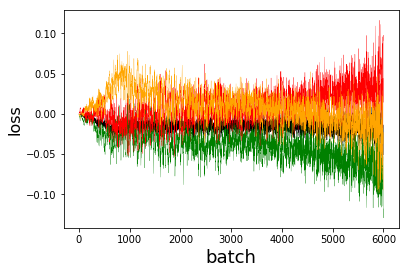

In [11]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

# plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()

In [12]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

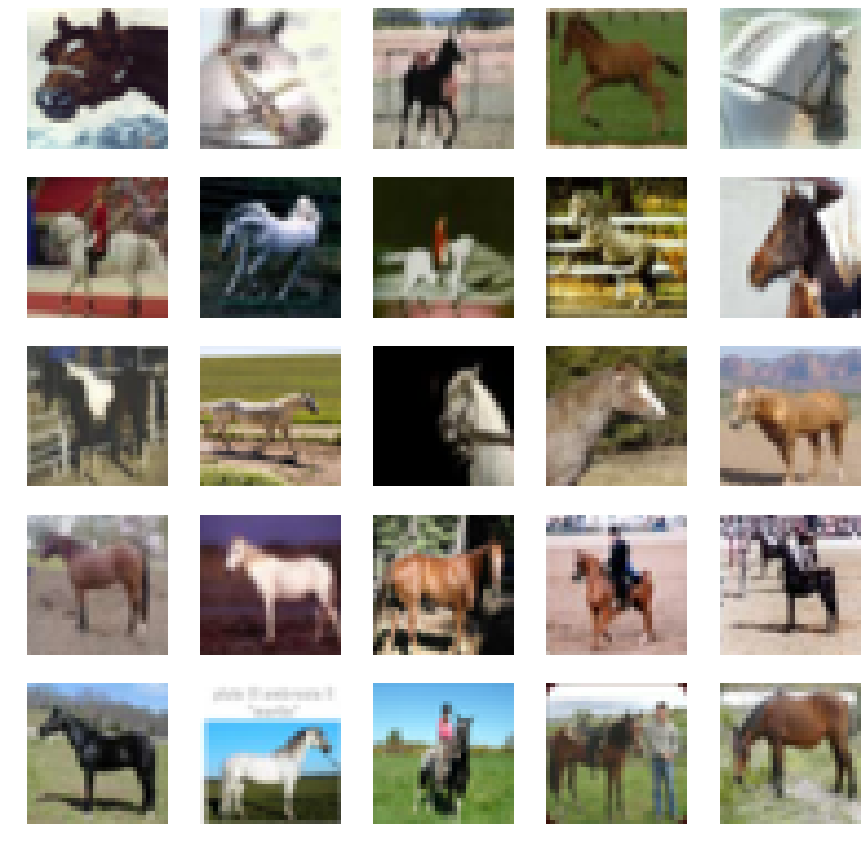

In [15]:
r, c = 5, 5

idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
true_imgs = (x_train[idx] + 1) *0.5

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(true_imgs[cnt], cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
# fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"))
# plt.close()

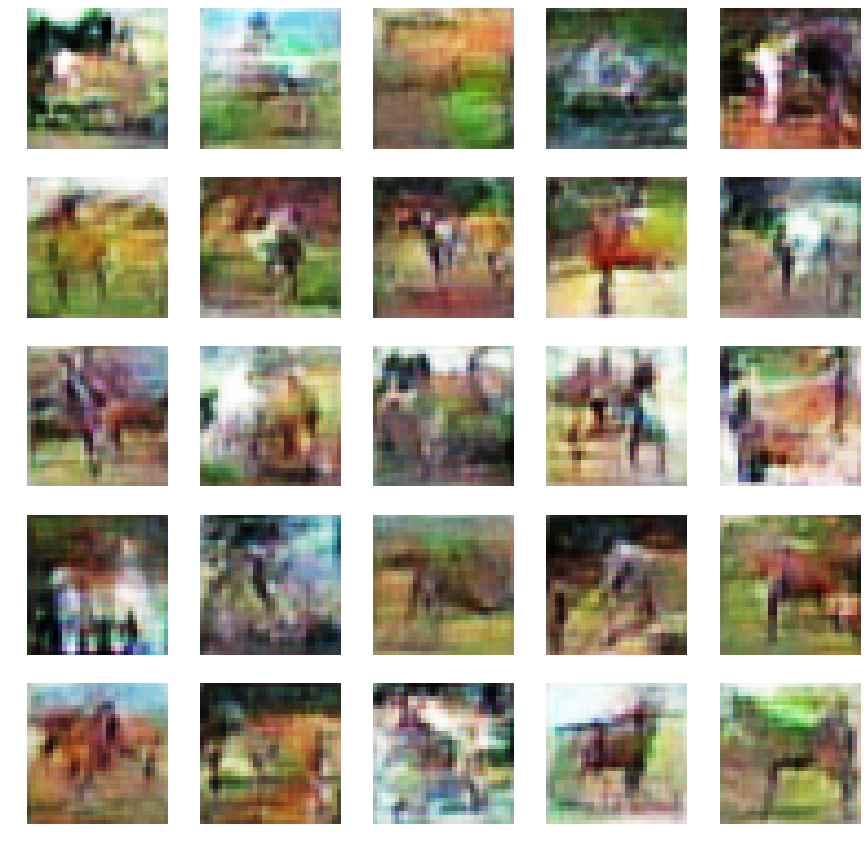

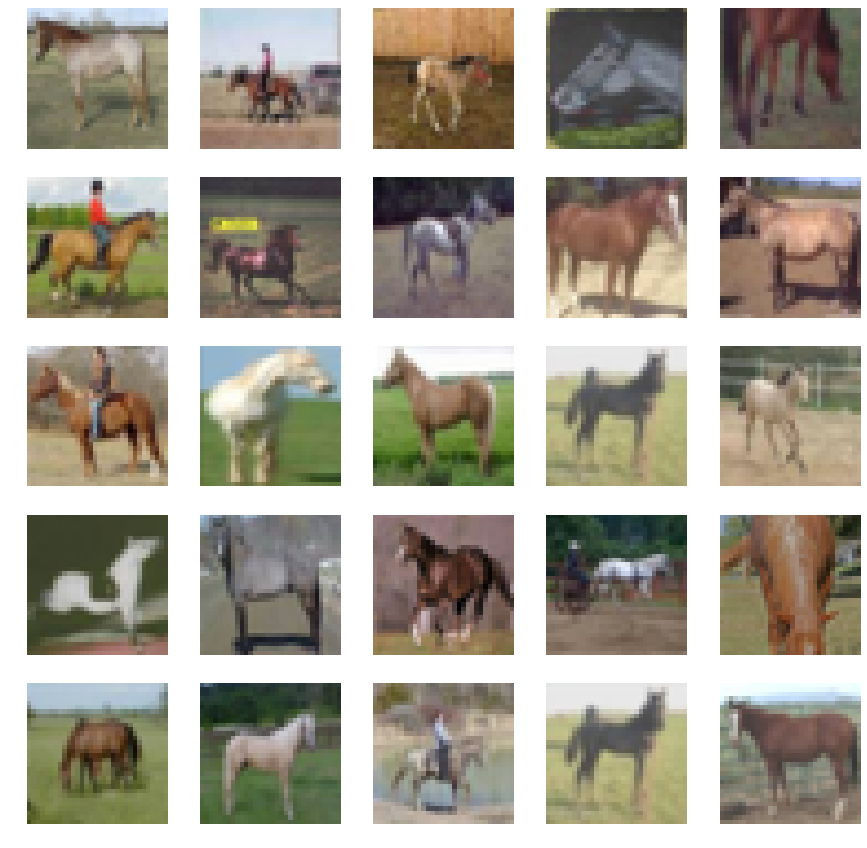

In [16]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, gan.z_dim))
gen_imgs = gan.generator.predict(noise)

#Rescale images 0 - 1

gen_imgs = 0.5 * (gen_imgs + 1)
# gen_imgs = np.clip(gen_imgs, 0, 1)

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1
# fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"))
# plt.close()


fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train + 1) * 0.5):
            
            diff = compare_images(gen_imgs[cnt, :,:,:], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img, cmap = 'gray_r')
        axs[i,j].axis('off')
        cnt += 1

# fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"))
# plt.close()